In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from up_down import get_up_down
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

# Load Data

In [3]:
data_path = "../../__data__/VAR/Wakeup_all"
data_files = [f for f in os.listdir(data_path) if f != "analysis"]

In [5]:
dbs_CIs = {}
areas = ['vlPFC', '7b', 'FEF', 'CPB', 'Thal']
for area in areas:
    dbs_CIs[area] = {}
    for score in range(7):
        dbs_CIs[area][score] = {'all_means': [], 'min_mean': [], 'all': [], 'N_highest': [], 'N_lowest': []}

In [8]:
N = 15
for index in tqdm(range(len(data_files))):
    filename = os.path.join(data_path, data_files[index])
    results = load(filename)
    
    PCA_dim = results['params']['PCA_dim']
    window = results['params']['window']
    stride = results['params']['stride']
    data_filename = results['params']['filename']
    electrode_info, lfp_schema, session_info, trial_info, unit_info = loadmat(data_filename, variables=['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo'], verbose=False)
    
    dbs_stimOn = [t for t, typ in zip(trial_info['dbs_stimOn'],trial_info['dbs_timingType']) if typ == 'train']
    dbs_stimOff = [t for t, typ in zip(trial_info['dbs_stimOff'],trial_info['dbs_timingType']) if typ == 'train']
    dbs_wakeScore = [s for s, typ in zip(trial_info['dbs_wakeScore'],trial_info['dbs_timingType']) if typ == 'train']
    
    for area in areas:
        criticality_inds = results[area]['eigs']

        for t_on, t_off, score in zip(dbs_stimOn, dbs_stimOff, dbs_wakeScore):
            if not np.isnan(score):
                on_step = int(t_on/stride)
                off_step = int(t_off/stride)
                dbs_CIs[area][score]['all_means'].extend(criticality_inds[on_step:off_step].mean(axis=1))
                dbs_CIs[area][score]['min_mean'].append(criticality_inds[on_step:off_step].mean(axis=1).min())
                dbs_CIs[area][score]['all'].extend(criticality_inds[on_step:off_step].flatten())
                
                N_highest = []
                N_lowest = []
                for t in range(criticality_inds[on_step:off_step].shape[0]):
                    args = criticality_inds[on_step:off_step][0].argsort()
                    N_highest.extend(criticality_inds[on_step:off_step][0][args[-N:]])
                    N_lowest.extend(criticality_inds[on_step:off_step][0][args[:N]])
                
                dbs_CIs[area][score]['N_highest'] = N_highest
                dbs_CIs[area][score]['N_lowest'] = N_lowest



    plot_dbs_only(results, window, stride, session_info, trial_info, data_path, data_filename)

  0%|          | 0/21 [00:00<?, ?it/s]

# 6 Scores

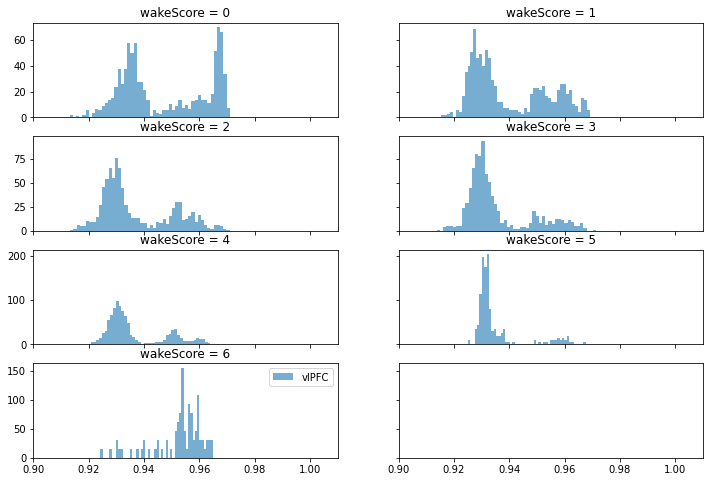

In [9]:
fig, axs = plt.subplots(4, 2, sharex='col', sharey='row', figsize=(12, 8))

for score in range(7):
    ax = axs[int(score/2)][score % 2]
    
    areas_colors = [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('Thal', 'midnightblue')]
    
    for area, c in [areas_colors[0]]:
        ax.hist(dbs_CIs[area][score]['all_means'], alpha=0.6, label=area, bins=50, density=True)
        ax.set_xlim([0.9, 1.01])
        
    ax.set_title(f"wakeScore = {score}")
ax.legend()
plt.show()

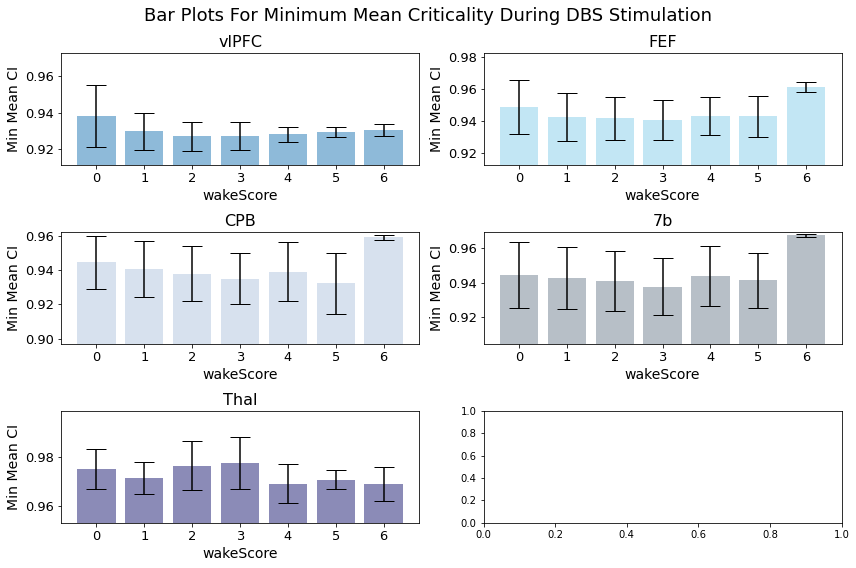

In [10]:
metric = 'min_mean'
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
    
areas_colors = [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('Thal', 'midnightblue')]
for i, (area, c) in enumerate(areas_colors):
    ax = axs[int(i/2)][i % 2]
    x_pos = np.arange(7)
    bar_heights = np.array([np.array(dbs_CIs[area][score][metric]).mean() for score in range(7)])
    error = [np.array(dbs_CIs[area][score][metric]).std() for score in range(7)]
    ax.bar(x_pos, bar_heights, yerr=error, align='center', alpha=0.5, color=c, ecolor='black', capsize=10)
    ax.set_title(area, fontsize=16)
    levels_min = bar_heights - error
    levels_max = bar_heights + error
    ax.set_ylim([levels_min.min() - error[levels_min.argmin()], levels_max.max() + error[levels_max.argmax()]])
    ax.set_xlabel('wakeScore', fontsize=14)
    ax.set_ylabel("Min Mean CI", fontsize=14)
    ax.tick_params(labelsize=13)
if metric == 'min_mean':
    plt.suptitle("Bar Plots For Minimum Mean Criticality During DBS Stimulation", fontsize=18)
elif metric == 'all_means':
    plt.suptitle("Bar Plots For Mean Criticality During DBS Stimulation", fontsize=18)
elif metric == 'all':
    plt.suptitle("Bar Plots For Criticality During DBS Stimulation", fontsize=18)
elif metric == 'N_highest':
    plt.suptitle(f"Bar Plots For {N} Highest CIs per Window During DBS Stimulation", fontsize=18)
elif metric == 'N_lowest':
    plt.suptitle(f"Bar Plots For {N} Lowest CIs per Window During DBS Stimulation", fontsize=18)
plt.tight_layout()
plt.show()

# 3 Scores

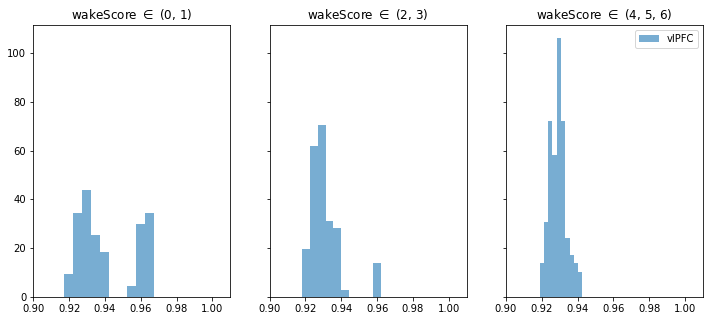

In [168]:
dbs_CIs_combined = {}
areas = ['vlPFC', '7b', 'FEF', 'CPB', 'Thal']
for area in areas:
    dbs_CIs_combined[area] = {}
    for score in range(3):
        dbs_CIs_combined[area][score] = {'all_means': [], 'min_mean': [], 'all': []}

for area in areas:
    for score in range(3):
        if score == 0:
            for key in ['all_means', 'min_mean', 'all']:
                dbs_CIs_combined[area][score][key] = np.hstack([dbs_CIs[area][0][key], dbs_CIs[area][1][key]])
        elif score == 1:
            for key in ['all_means', 'min_mean', 'all']:
                dbs_CIs_combined[area][score][key] = np.hstack([dbs_CIs[area][2][key], dbs_CIs[area][3][key]])
        else: # score == 2
            for key in ['all_means', 'min_mean', 'all']:
                dbs_CIs_combined[area][score][key] = np.hstack([dbs_CIs[area][4][key], dbs_CIs[area][5][key], dbs_CIs[area][6][key]])

fig, axs = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(12, 5))
              
for score in range(3):
    ax = axs[score]
    
    areas_colors = [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('Thal', 'midnightblue')]
    
    for area, c in [areas_colors[0]]:
        ax.hist(dbs_CIs_combined[area][score]['min_mean'], alpha=0.6, label=area, density=True)
        ax.set_xlim([0.9, 1.01])
    if score == 0:
        ax.set_title(fr"wakeScore $\in$ {0, 1}")
    elif score == 1:
        ax.set_title(fr"wakeScore $\in$ {2, 3}")
    elif score == 2:
        ax.set_title(fr"wakeScore $\in$ {4, 5, 6}")
ax.legend()
plt.show()

## Combined 2

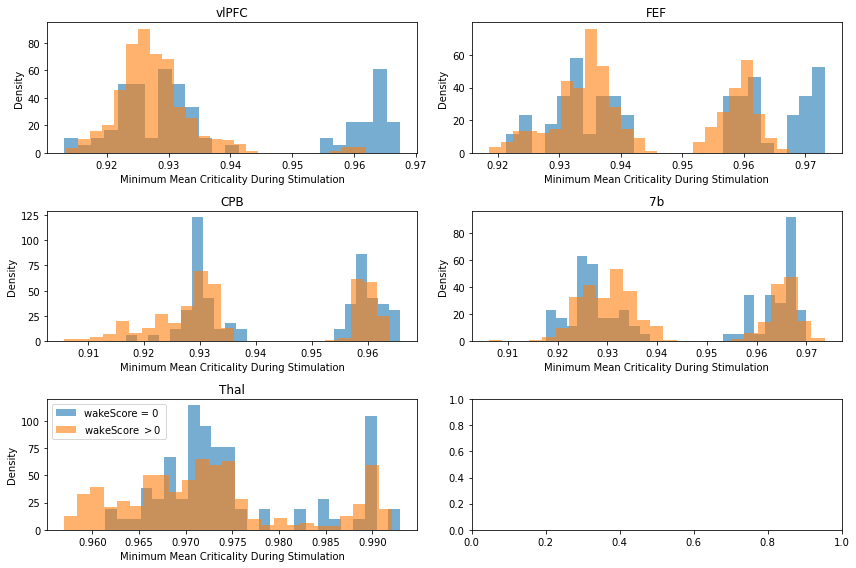

In [12]:
dbs_CIs_combined = {}
areas = ['vlPFC', '7b', 'FEF', 'CPB', 'Thal']
keys = ['all_means', 'min_mean', 'all', 'N_highest', 'N_lowest']
for area in areas:
    dbs_CIs_combined[area] = {}
    for score in range(2):
        dbs_CIs_combined[area][score] = {'all_means': [], 'min_mean': [], 'all': []}

for area in areas:
    for score in range(2):
        if score == 0:
            for key in keys:
                dbs_CIs_combined[area][score][key] = dbs_CIs[area][0][key]
        elif score == 1:
            for key in keys:
                dbs_CIs_combined[area][score][key] = np.hstack([dbs_CIs[area][i][key] for i in range(1, 7)])

fig, axs = plt.subplots(3, 2, figsize=(12, 8))
    
areas_colors = [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('Thal', 'midnightblue')]
for i, (area, _) in enumerate(areas_colors):
    ax = axs[int(i/2)][i % 2]
    for score in range(2):
        ax.hist(dbs_CIs_combined[area][score]['min_mean'], alpha=0.6, label=fr"wakeScore = 0 " if score == 0 else fr"wakeScore $ > 0$", density=True, bins=25)
    ax.set_title(area)
    ax.set_xlabel("Minimum Mean Criticality During Stimulation")
    ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()
plt.show()

In [22]:
from scipy.stats import t

In [26]:
p = 2*t.sf(t_stat, df=n1 + n2 - 2)

In [24]:
t, t_stat

(<scipy.stats._continuous_distns.t_gen at 0x7f78b5c25940>, 0.22059788682905734)

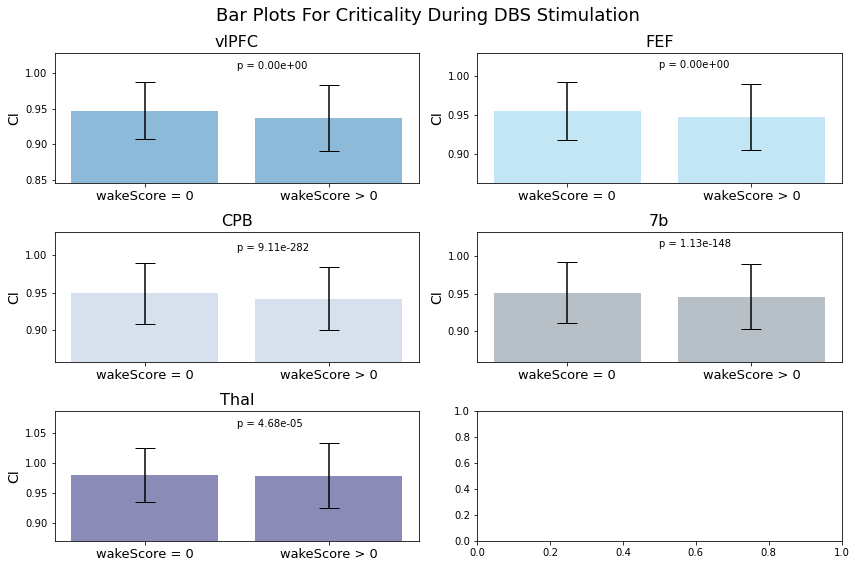

In [43]:
metric = 'all'

if metric == 'min_mean':
    suptitle = "Bar Plots For Minimum Mean Criticality During DBS Stimulation"
    ylabel = "Min Mean CI"
elif metric == 'all_means':
    suptitle = "Bar Plots For Mean Criticality During DBS Stimulation"
    ylabel = "Mean CI"
elif metric == 'all':
    suptitle = "Bar Plots For Criticality During DBS Stimulation"
    ylabel = "CI"
elif metric == 'N_highest':
    suptitle = f"Bar Plots For {N} Highest CIs per Window During DBS Stimulation"
    ylabel = f"{N} Highest CI"
elif metric == 'N_lowest':
    suptitle = f"Bar Plots For {N} Lowest CIs per Window During DBS Stimulation"
    ylabel = f"{N} Lowest CI"

fig, axs = plt.subplots(3, 2, figsize=(12, 8))
    
areas_colors = [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('Thal', 'midnightblue')]
for i, (area, c) in enumerate(areas_colors):
    ax = axs[int(i/2)][i % 2]
    x_pos = np.arange(2)
    bar_heights = np.array([np.array(dbs_CIs_combined[area][score][metric]).mean() for score in range(2)])
    error = [np.array(dbs_CIs_combined[area][score][metric]).std() for score in range(2)]
    ax.bar(x_pos, bar_heights, yerr=error, align='center', alpha=0.5, color=c, ecolor='black', capsize=10)
    ax.set_title(area, fontsize=16)
    levels_min = bar_heights - error
    levels_max = bar_heights + error
    
    # t-test
    n1 = len(dbs_CIs_combined[area][0][metric])
    n2 = len(dbs_CIs_combined[area][1][metric])
    mean_1 = bar_heights[0]
    mean_2 = bar_heights[1]
    var_1 = error[0]**2
    var_2 = error[1]**2
    s_squared = (n1 - 1)/(n1 + n2 - 2)*var_1 + (n2 - 1)/(n1 + n2 - 2)*var_2
    t_stat = (mean_1 - mean_2)/(np.sqrt(s_squared)*np.sqrt((1/n1) + (1/n2)))
    p = 2*t.sf(t_stat, df=n1 + n2 - 2)
    
    ax.text(0.5, bar_heights[1] + 1.5*error[1], f"p = {p:.6f}" if p > 0.0001 else f"p = {p:.2e}" )
    ax.set_ylim([levels_min.min() - error[levels_min.argmin()], levels_max.max() + error[levels_max.argmax()]])
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['wakeScore = 0', fr'wakeScore > 0'], fontsize=13)
plt.suptitle(suptitle, fontsize=18)
plt.tight_layout()
plt.show()

# Plotting

In [7]:
def plot_full(results, window, stride, session_info, trial_info, data_path, data_filename):
    fig = plt.figure(figsize=(15, 8))
    ax = plt.gca()

    min_val = np.Inf
    max_val = -np.Inf

    start_ind = 50
    end_ind = len(results['vlPFC']['eigs'])

    if 'Wakeup' in data_path:
        areas_colors = [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('Thal', 'midnightblue')]
    else:
        areas_colors = [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray')]

    for area, c in areas_colors:
    # for area, c in [('vlPFC', 'C0')]:
        start_times = np.arange(results[area]['eigs'].shape[0])*stride/60
        criticality_inds = results[area]['eigs'].mean(axis=1)

        start_times = start_times[start_ind:]
        criticality_inds = criticality_inds[start_ind:]
        ax.plot(start_times, criticality_inds, label=area, c=c)

        if criticality_inds.min() < min_val:
            min_val = criticality_inds.min()
        if criticality_inds.max() > max_val:
            max_val = criticality_inds.max()

    # min_val = criticality_inds.min()
    # max_val = criticality_inds.max()

    ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], stride)/60, 
                                    min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
    ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
                            min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 2 - dose = {session_info['drugDose'][1]}")

    if np.sum(session_info['eyesClose']) < 10:
        plt.axvline(session_info['eyesClose'][0]/60, linestyle='--', c='red', label="loss of consciousness")
        plt.axvline(session_info['eyesClose'][1]/60, linestyle='--', c='green', label="return of consciousness")
    else:
        plt.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
        plt.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")


    if 'Wakeup' in data_path:
        dbs_bool = np.zeros(len(criticality_inds))
        for i, (t_on, t_off, timing_type) in enumerate(zip(trial_info['dbs_stimOn'], trial_info['dbs_stimOff'], trial_info['dbs_timingType'])):
            if timing_type == 'train':
                dbs_bool[int(t_on/stride) - start_ind:int(t_off/stride) - start_ind] = 1

        ax.fill_between(start_times, min_val, max_val, where=dbs_bool, color='orange', alpha=0.6, label='DBS')



    ax.legend(fontsize=14)        
    fig.text(0.52, -0.02, 'Time (min)', ha='center', fontsize=16)
    ax.set_ylabel('Mean Criticality Index', fontsize=16)
    ax.tick_params(labelsize=13)
    plt.suptitle("Mean Criticality Index of VAR Transition Matrix - Monkey 1\nWindow = 2.5 s", fontsize=18)
    plt.tight_layout()
    data_dir = os.path.join(data_path, "analysis", "plots")
    os.makedirs(data_dir, exist_ok=True)
    plt.savefig(os.path.join(data_dir, f"{os.path.basename(data_filename)[:-4]}_full.png"))
    plt.close()

    
def plot_dbs_only(results, window, stride, session_info, trial_info, data_path, data_filename):
    fig = plt.figure(figsize=(15, 8))

    min_val = np.Inf
    max_val = -np.Inf
    start_ind = np.max([int((trial_info['dbs_stimOn'][0] - 180)/stride), 0])
    end_ind = int(([t for t, typ in zip(trial_info['dbs_stimOff'], trial_info['dbs_timingType']) if typ == 'train'][-1] + 180)/stride)
    
    if 'Wakeup' in data_path:
        areas_colors = [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('Thal', 'midnightblue')]
    else:
        areas_colors = [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray')]

    for area, c in areas_colors:
    # for area, c in [('vlPFC', 'C0')]:
        start_times = np.arange(results[area]['eigs'].shape[0])*stride/60
        criticality_inds = results[area]['eigs'].mean(axis=1)
        start_times = start_times[start_ind:end_ind]
        criticality_inds = criticality_inds[start_ind:end_ind]
        plt.plot(start_times, criticality_inds, label=area, c=c)

        if criticality_inds.min() < min_val:
            min_val = criticality_inds.min()
        if criticality_inds.max() > max_val:
            max_val = criticality_inds.max()

    # min_val = criticality_inds.min()
    # max_val = criticality_inds.max()


    if 'Wakeup' in data_path:
        dbs_bool = np.zeros((7, len(criticality_inds)))
        for i, (t_on, t_off, timing_type, score) in enumerate(zip(trial_info['dbs_stimOn'], trial_info['dbs_stimOff'], trial_info['dbs_timingType'], trial_info['dbs_wakeScore'])):
            if timing_type == 'train' and not np.isnan(score):
                score = int(score)
                dbs_bool[score, int(t_on/stride) - start_ind:int(t_off/stride) - start_ind] = 1

        for score in range(7):
            plt.fill_between(start_times, min_val, max_val, where=dbs_bool[score], color='orange', alpha=score/6, label=f'DBS - wakeScore {score}')

    plt.legend(fontsize=14)        
    plt.xlabel('Time (min)', fontsize=16)
    plt.ylabel('Mean Criticality Index', fontsize=16)
    plt.tick_params(labelsize=13)
    plt.suptitle("Mean Criticality Index of VAR Transition Matrix (DBS Only) - Monkey 1\nWindow = 2.5 s", fontsize=18)
    plt.tight_layout()
    data_dir = os.path.join(data_path, "analysis", "plots")
    os.makedirs(data_dir, exist_ok=True)
    plt.savefig(os.path.join(data_dir, f"{os.path.basename(data_filename)[:-4]}_dbs_only.png"))
    plt.close()

In [50]:
plot_dbs_only(results, window, stride, session_info, trial_info, data_path, data_filename)

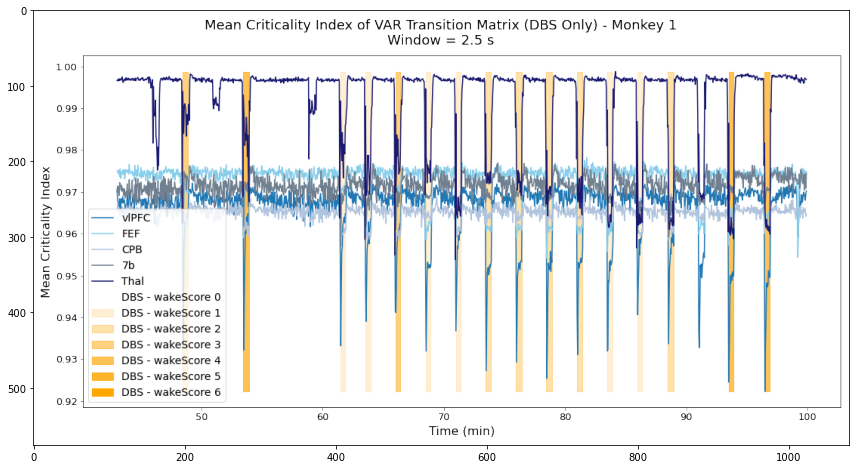

In [51]:
plt.figure(figsize=(15, 8))
im = plt.imread(os.path.join(data_path, "analysis", "plots", f"{os.path.basename(data_filename)[:-4]}_dbs_only.png"))
plt.imshow(im)
plt.show()

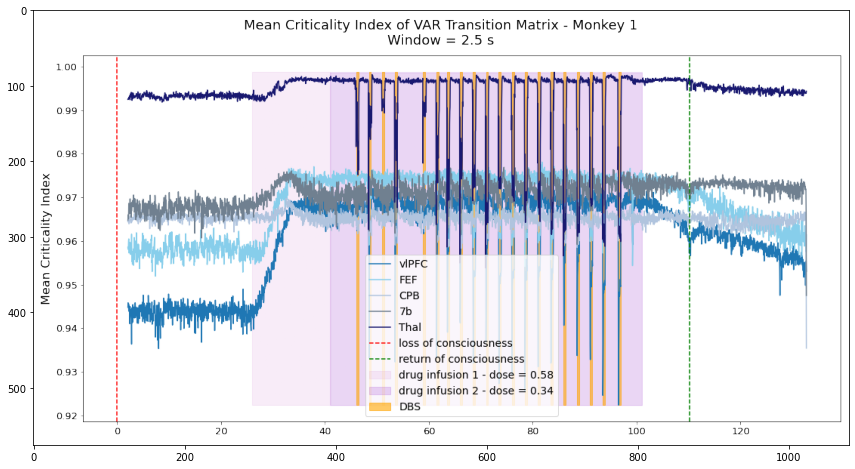

In [41]:
plt.figure(figsize=(15, 8))
im = plt.imread(os.path.join(data_path, "analysis", "plots", f"{os.path.basename(data_filename)[:-4]}_full.png"))
plt.imshow(im)
plt.show()

In [ ]:
def plot_dbs_only()